In [15]:
import pathlib as pl
from configparser import ConfigParser
from math import factorial
import itertools as itt
from collections import defaultdict

import joblib as jl
import numpy as np
import scipy.stats as sst
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Image

from src.data.load import load
from src.visualization.interactive import plot_raw_pair, plot_pupil_so_effects
from src.root_path import config_path
from src.visualization.palette import *
from src.utils.dataframes import add_classified_contexts

config = ConfigParser()
config.read_file(open(config_path / 'settings.ini'))

In [10]:
 # Cluster Mass significant contextual effects
summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220719_chunked_amplitude_DF'

metrics = ['integral', 'integral_A', 'integral_B', 'integral_C', 'integral_D',]
DF = jl.load(summary_DF_file).query(f"source == 'real' and metric in {metrics} and "
                                    f"cluster_threshold == 0.05 and mult_comp_corr == 'bf_cp' and "
                                    f"analysis == 'SC' and "
                                    f"value > 0 and value < 10000")

DF['chunk'] = DF['metric'].str.split('_').str[-1]
DF.loc[:,'chunk'].replace({'integral': 'full'}, inplace=True)

DF.drop(columns=['source', 'cluster_threshold', 'mult_comp_corr',
                 'analysis', 'metric', 'stim_count',], inplace=True)
DF.reset_index(drop=True, inplace=True)

for col in ['id','context_pair','probe','site', 'region', 'chunk']:
    DF[col] = DF[col].astype('category')

DF['value'] = pd.to_numeric(DF.value, downcast='float')
DF.head()

,id,context_pair,probe,value,site,region,chunk
0,AMT029a-35-1,00_01,1,540.689758,AMT029a,PEG,full
1,AMT029a-43-1,00_01,1,542.716431,AMT029a,PEG,full
2,AMT029a-48-1,00_01,1,432.214355,AMT029a,PEG,full
3,AMT029a-51-1,00_01,1,358.975830,AMT029a,PEG,full
4,AMT029a-57-1,00_01,1,336.460602,AMT029a,PEG,full


In [11]:
# Cluster Mass significant contextual effects
summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220804_significant_abs_deltaFR_DF'

metrics = ['integral', 'integral_A', 'integral_B', 'integral_C', 'integral_D',]
DF2 = jl.load(summary_DF_file).query(f"source == 'real' and metric in {metrics} and "
                                    f"cluster_threshold == 0.05 and mult_comp_corr == 'bf_cp' and "
                                    f"analysis == 'SC' and "
                                    f"value > 0 and value < 10000")

DF2['chunk'] = DF2['metric'].str.split('_').str[-1]
DF2.loc[:,'chunk'].replace({'integral': 'full'}, inplace=True)

DF2.drop(columns=['source', 'cluster_threshold', 'mult_comp_corr',
                 'analysis', 'metric', 'stim_count',], inplace=True)
DF2.reset_index(drop=True, inplace=True)

for col in ['id','context_pair','probe','site', 'region', 'chunk']:
    DF2[col] = DF2[col].astype('category')

DF2['value'] = pd.to_numeric(DF2.value, downcast='float')
DF2.head()

,id,context_pair,probe,value,site,region,chunk
0,CRD004a-22-1,00_01,1,151.889679,CRD004a,A1,full
1,CRD004a-39-2,00_01,1,45.823387,CRD004a,A1,full
2,CRD004a-46-3,00_01,1,349.813538,CRD004a,A1,full
3,CRD004a-62-1,00_01,1,128.190765,CRD004a,A1,full
4,CRD004a-64-1,00_01,1,346.058807,CRD004a,A1,full


# difference between T-score and Dfr
the absolute significant integral can be calculated directly over the T-score used to calculate cluster mass and
and significance, but a more easy to understand metric would use the same significacen and just calculate the
delta mean firing rate at significant time bins, and then calculate the absolute integral over these delta-FRs

In [12]:
merged  = pd.merge(DF, DF2, on=['id', 'context_pair', 'probe', 'chunk'], suffixes=('_tscore', '_dfr'), validate='1:1')
del(DF, DF2)

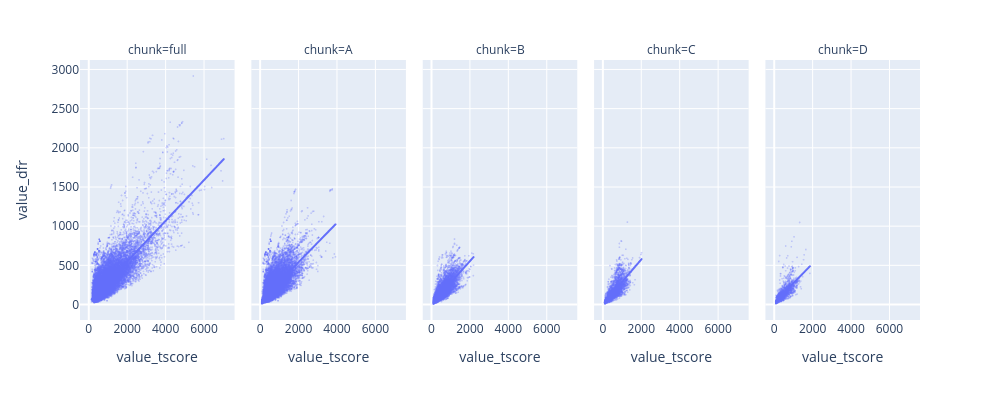

In [13]:
fig = px.scatter(merged,x='value_tscore', y='value_dfr', facet_col='chunk', trendline='ols')
fig.update_traces(marker=dict(size=2, opacity=0.3))
# fig.show()
img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

# Fold
into columns corresponding to categories, as one hot encoding

In [17]:
# Cluster Mass significant contextual effects
summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220804_significant_abs_deltaFR_DF'

metrics = ['integral', 'last_bin']
DF = jl.load(summary_DF_file).query(f"source == 'real' and metric in {metrics} and "
                                    f"cluster_threshold == 0.05 and mult_comp_corr == 'bf_cp' and "
                                    f"analysis == 'SC' and "
                                    f"value > 0 and value < 10000")

DF.drop(columns=['source', 'cluster_threshold', 'mult_comp_corr',
                 'analysis', 'stim_count',], inplace=True)
DF.reset_index(drop=True, inplace=True)
DF = add_classified_contexts(DF)

for col in ['id','context_pair','probe','site', 'region', 'metric', 'trans_pair']:
    DF[col] = DF[col].astype('category')

DF['value'] = pd.to_numeric(DF.value, downcast='float')
print(DF.shape)
DF.head()

(91816, 8)


,id,context_pair,probe,value,metric,site,region,trans_pair
0,CRD004a-22-1,00_01,1,151.889679,integral,CRD004a,A1,same_silence
1,CRD004a-39-2,00_01,1,45.823387,integral,CRD004a,A1,same_silence
2,CRD004a-46-3,00_01,1,349.813538,integral,CRD004a,A1,same_silence
3,CRD004a-62-1,00_01,1,128.190765,integral,CRD004a,A1,same_silence
4,CRD004a-64-1,00_01,1,346.058807,integral,CRD004a,A1,same_silence


In [109]:
# toregress= DF.head(100).copy()
toregress= DF

# the simplest approach is to manually map the 4 categories into onehots
# onehot order: diff1 diff2 same silence
mapper={'diff_diff':(1,1,0,0), 'diff_same':(1,0,1,0), 'diff_silence':(1,0,0,1), 'same_silence':(0,0,1,1)}
toregress['onehot'] = toregress['trans_pair'].replace(mapper)
onehotdf = pd.DataFrame(toregress['onehot'].to_list(), columns = ['diff1', 'diff2', 'same', 'silence'])

toregress = pd.concat([toregress, onehotdf], axis=1)

toregress.drop(columns='onehot', inplace=True)
del(onehotdf)

for col in ['diff1', 'diff2', 'same', 'silence']:
    toregress[col] = toregress[col].astype('category')

toregress

,id,context_pair,probe,value,metric,site,region,trans_pair,diff1,diff2,same,silence
0,CRD004a-22-1,00_01,1,151.889679,integral,CRD004a,A1,same_silence,0,0,1,1
1,CRD004a-39-2,00_01,1,45.823387,integral,CRD004a,A1,same_silence,0,0,1,1
2,CRD004a-46-3,00_01,1,349.813538,integral,CRD004a,A1,same_silence,0,0,1,1
3,CRD004a-62-1,00_01,1,128.190765,integral,CRD004a,A1,same_silence,0,0,1,1
4,CRD004a-64-1,00_01,1,346.058807,integral,CRD004a,A1,same_silence,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
91811,AMT030a-22-1,01_04,4,100.000000,last_bin,AMT030a,PEG,diff_same,1,0,1,0
91812,AMT030a-27-1,01_04,4,150.000000,last_bin,AMT030a,PEG,diff_same,1,0,1,0
91813,AMT030a-22-1,02_04,4,100.000000,last_bin,AMT030a,PEG,diff_same,1,0,1,0
91814,AMT030a-22-2,02_04,4,200.000000,last_bin,AMT030a,PEG,diff_same,1,0,1,0


In [110]:
from statsmodels.formula.api import ols

mod = ols("value ~ C(diff1) * C(diff2) * C(same) * C(silence)", data=toregress.query("metric == 'integral'"))
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     117.9
Date:                Wed, 10 Aug 2022   Prob (F-statistic):          2.14e-148
Time:                        17:18:00   Log-Likelihood:            -3.0560e+05
No. Observations:               45908   AIC:                         6.112e+05
Df Residuals:                   45901   BIC:                         6.113e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

/auto/users/mateo/miniconda3/envs/cpa_tf/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1918: RuntimeWarning:

divide by zero encountered in double_scalars



In [113]:
# get weiths and intecep, remove non existing interactions
weights = res.params
weights.name = 'value'
weights = weights.reset_index()
weights.rename(columns={'index':'parameter'}, inplace=True)
weights = weights.query("value != 0")

# rename parameters to remove extra statsmodel notation
names = weights['parameter'].str.extractall(r"\((.*?)\)")
names = names.groupby(level=0).apply(lambda x: '_'.join(x[0]))
weights.loc[1:,'parameter'] = names
weights

,parameter,value
0,Intercept,-2.157282e+12
1,diff1,-5.500820e+13
2,diff2,3.383681e+13
3,same,7.804787e+13
4,silence,-4.149714e+13
5,diff1_diff2,2.332867e+13
6,diff1_same,-2.088238e+13
7,diff2_same,1.574779e-02
8,diff1_silence,9.866262e+13
10,same_silence,-3.439345e+13


In [114]:
fig = px.bar(weights, x='parameter', y='value')
fig.show()